In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from scripts.u_net import UNet
from scripts.nn_blocks import device

print(f"Using device: {device}")

Using device: mps


## 1. Setup & Load Model
We need to redefine the diffusion schedule and model architecture to match training.

In [2]:
# --- Configuration ---
T = 1000
num_classes = 10 # FashionMNIST
unet_base_channel = 128
checkpoint_epoch = 25 # Change this to your desired checkpoint index

# --- Diffusion Schedule ---
# Must match the training schedule exactly
alphas = torch.linspace(start=0.9999, end=0.98, steps=T, dtype=torch.float32).to(device)
alpha_bars = torch.cumprod(alphas, dim=0)

# --- Class Map ---
label_to_name_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
}
class_list = list(label_to_name_map.values())

In [3]:
# --- Init Model ---
emb = nn.Embedding(num_classes, unet_base_channel*4).to(device)
unet = UNet(
    source_channel=1, # FashionMNIST is grayscale
    unet_base_channel=unet_base_channel,
    num_norm_groups=32,
).to(device)

# --- Load Weights ---
try:
    unet_path = f"../checkpoints/guided_unet_{checkpoint_epoch}.pt"
    emb_path = f"../checkpoints/guided_embedding_{checkpoint_epoch}.pt"
    
    unet.load_state_dict(torch.load(unet_path, map_location=device))
    emb.load_state_dict(torch.load(emb_path, map_location=device))
    
    unet.eval()
    print(f"Successfully loaded checkpoints from '{unet_path}'")
except FileNotFoundError:
    print(f"Error: Checkpoints not found. Please check the path.")

Successfully loaded checkpoints from '../checkpoints/guided_unet_25.pt'


## 2. DDPM Inference (Standard)
This method samples step-by-step from $T$ down to $0$, adding random noise ($\sigma_t z$) at each step.

In [ ]:
def run_inference_ddpm(unet, emb, class_name, s, num_row=5, num_col=5):
    print(f"Running DDPM Sampling (T={T})... this might take a while.")
    unet.eval()
    
    # Calculate sigmas for the noise addition
    alpha_bars_prev = torch.cat((torch.ones(1).to(device), alpha_bars[:-1]))
    sigma_t = torch.sqrt((1.0 - alphas) * (1.0 - alpha_bars_prev) / (1.0 - alpha_bars))

    # Start with pure noise
    x = torch.randn(num_row*num_col, 1, 32, 32).to(device)

    with torch.no_grad():
        # Prepare embeddings
        label_idx = list(label_to_name_map.values()).index(class_name)
        y = torch.tensor([label_idx] * (num_row * num_col)).to(device)
        
        y_emb_cond = emb(y)
        y_emb_uncond = torch.zeros_like(y_emb_cond)
        y_emb_batch = torch.cat([y_emb_cond, y_emb_uncond], dim=0) # [Cond, Uncond]
        
        # Reverse Loop
        for t in tqdm(reversed(range(T)), total=T, desc="DDPM"):
            # Time batch
            t_batch = torch.full((num_row*num_col*2,), t, device=device, dtype=torch.long)
            
            # Input batch (doubled for CFG)
            x_batch = torch.cat([x, x], dim=0)
            
            # Predict noise
            eps_batch = unet(x_batch, t_batch, y_emb_batch)
            eps_cond, eps_uncond = torch.split(eps_batch, num_row*num_col, dim=0)
            
            # Guidance
            eps = (1.0 + s) * eps_cond - s * eps_uncond
            
            # Update Step
            if t > 0:
                z = torch.randn_like(x)
            else:
                z = torch.zeros_like(x)
                
            x = (1.0 / torch.sqrt(alphas[t])) * (x - ((1.0 - alphas[t]) / torch.sqrt(1.0 - alpha_bars[t])) * eps) + \
                sigma_t[t] * z

    # Plot
    x = x.permute(0, 2, 3, 1).cpu().clamp(0, 1)
    fig, axes = plt.subplots(num_row, num_col, figsize=(6,6))
    fig.suptitle(f"DDPM Results: {class_name} (s={s})")
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.imshow(x[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.show()
    # plt.savefig(f"ddpm_{class_name}_s{s}.png")

## 3. DDIM Inference (Fast)
This method takes "shortcuts" (e.g., jumps 20 steps at a time) and uses a deterministic update rule (no random noise added during sampling).

In [ ]:
def run_inference_ddim(unet, emb, class_name, s, n_steps=50, num_row=5, num_col=5):
    print(f"Running DDIM Sampling (Steps={n_steps})... Fast!")
    unet.eval()

    # Time subsequence
    step_size = T // n_steps
    timesteps = list(range(0, T, step_size))
    timesteps = sorted(timesteps, reverse=True)
    
    # Start with pure noise
    x = torch.randn(num_row*num_col, 1, 32, 32).to(device)

    with torch.no_grad():
        # Prepare embeddings
        label_idx = list(label_to_name_map.values()).index(class_name)
        y = torch.tensor([label_idx] * (num_row * num_col)).to(device)
        
        y_emb_cond = emb(y)
        y_emb_uncond = torch.zeros_like(y_emb_cond)
        y_emb_batch = torch.cat([y_emb_cond, y_emb_uncond], dim=0) 

        for t in tqdm(timesteps, desc="DDIM"):
            # Time batch
            t_batch = torch.full((num_row*num_col*2,), t, device=device, dtype=torch.long)
            x_batch = torch.cat([x, x], dim=0)
            
            # Predict noise
            eps_batch = unet(x_batch, t_batch, y_emb_batch)
            eps_cond, eps_uncond = torch.split(eps_batch, num_row*num_col, dim=0)
            
            # Guidance
            eps = (1.0 + s) * eps_cond - s * eps_uncond

            # Calculate update variables
            alpha_bar_t = alpha_bars[t]
            prev_t = t - step_size
            if prev_t >= 0:
                alpha_bar_prev = alpha_bars[prev_t]
            else:
                alpha_bar_prev = torch.tensor(1.0).to(device)
            
            # 1. Predict x0
            pred_x0 = (x - torch.sqrt(1 - alpha_bar_t) * eps) / torch.sqrt(alpha_bar_t)
            
            # 2. Point to x_{t-1} (Deterministic)
            dir_xt = torch.sqrt(1 - alpha_bar_prev) * eps
            
            # 3. Update x
            x = torch.sqrt(alpha_bar_prev) * pred_x0 + dir_xt

    # Plot
    x = x.permute(0, 2, 3, 1).cpu().clamp(0, 1)
    fig, axes = plt.subplots(num_row, num_col, figsize=(6,6))
    fig.suptitle(f"DDIM Results: {class_name} (s={s}, steps={n_steps})")
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.imshow(x[i, :, :, 0], cmap='gray')
        ax.axis('off')
    # plt.savefig(f"ddim_{class_name}_s{s}_steps{n_steps}.png")
    plt.show()

## 4. DPS Inference (Inpainting Demo)
Implementation of **Diffusion Posterior Sampling** (Chung et al. 2022).
We will use the pre-trained diffusion model to solve an inverse problem: **Inpainting**.
We simulate a measurement $y = M \odot x$ (where $M$ is a binary mask) and use DPS to sample from $p(x | y)$.
The gradient update is: $\nabla_{x_t} \log p(y|x_t) \simeq \nabla_{x_t} || y - M \odot \hat{x}_0(x_t) ||^2$.

In [ ]:
def run_inference_dps(unet, emb, class_name, s, measurement, mask, zeta=1.0, steps=50):
    """
    Runs Diffusion Posterior Sampling for INPAINTING.
    measurement: Tensor [B, 1, 32, 32] (Range 0-1)
    mask: Tensor [B, 1, 32, 32] (1 = keep, 0 = drop)
    """
    print(f"Running DPS Inpainting... (Class: {class_name}, Scale: {s})")
    unet.eval()

    n = 1
    # Start with pure noise
    x = torch.randn(n, 1, 32, 32).to(device)
    label_idx = list(label_to_name_map.values()).index(class_name)
    y = torch.tensor([label_idx] * (n * n)).to(device)
        
    y_emb_cond = emb(y)
    y_emb_uncond = torch.zeros_like(y_emb_cond)
    y_emb_batch = torch.cat([y_emb_cond, y_emb_uncond], dim=0) # [Cond, Uncond]

    # Setup Measurement
    y_meas = measurement.to(device).view(1, 1, 32, 32)
    mask = mask.to(device).view(1, 1, 32, 32)
    
    # Create DDIM Time Schedule (e.g., 999 -> 0 in 50 steps)
    T = 1000
    skip = T // steps
    time_seq = list(reversed(range(0, T, skip)))
        
    # Reverse Loop
    for i,t in enumerate(time_seq):
        x = x.detach().requires_grad_(True)
        # Time batch
        t_batch = torch.full((n*n*2,), t, device=device, dtype=torch.long)
        
        # Input batch (doubled for CFG)
        x_batch = torch.cat([x, x], dim=0)
        
        # Predict noise
        eps_batch = unet(x_batch, t_batch, y_emb_batch)
        eps_cond, eps_uncond = torch.split(eps_batch, n*n, dim=0)
        
        # Guidance
        noise_pred = (1.0 + s) * eps_cond - s * eps_uncond
    
    # --- B. DPS: Gradient Calculation ---
        # 1. Estimate x0 (using current alpha_bar)
        alpha_bar_t = alpha_bars[t]
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        
        # Tweedie's Formula to estimate clean image
        x0_hat = (x - sqrt_one_minus_alpha_bar_t * noise_pred) / sqrt_alpha_bar_t

        x0_hat = x0_hat.clamp(0, 1)

        # 2. Calculate Loss (Compare x0_hat to measurement)
        # We only look at errors inside the mask
        difference = mask * (x0_hat - y_meas)
        loss = torch.norm(difference)**2
        
        # 3. Compute Gradient
        grad = torch.autograd.grad(loss, x)[0]
        
        # --- C. DPS: Apply Nudge ---
        # We subtract the gradient from x. 
        # Note: We detach() here because we are done with gradients for this step.
        x_nudged = x.detach() - zeta * grad

        if i % 10 == 0:
            print(f"Step {i}/{steps} | t={t} | Loss: {loss.item():.4f} | |Grad|: {grad.norm().item():.4f} | x_range: [{x.min():.2f}, {x.max():.2f}]")
        
        # --- D. DDIM Update (Deterministic) ---
        # Now we proceed with the standard DDIM update using x_nudged
        
        # Re-calculate prediction on the NUDGED x if desired (Optional but strictly more correct)
        # For speed, we often reuse 'noise_pred' but treating x_nudged as the new base.
        # Let's do the fast approximation: assume noise_pred is still valid for x_nudged.
        
        # Get Previous Timestep
        if i == len(time_seq) - 1:
            t_prev = -1
            alpha_bar_prev = torch.tensor(1.0).to(device)
        else:
            t_prev = time_seq[i+1]
            alpha_bar_prev = alpha_bars[t_prev]

        # 1. Re-estimate x0 using the nudged x
        # (This ensures the update trajectory respects the nudge)
        pred_x0 = (x_nudged - sqrt_one_minus_alpha_bar_t * noise_pred) / sqrt_alpha_bar_t
        pred_x0 = pred_x0.clamp(0, 1)
        
        # 2. Point to next step (Direction to x_{t-1})
        dir_xt = torch.sqrt(1 - alpha_bar_prev) * noise_pred
        
        # 3. Move to x_{t-1}
        x_prev = torch.sqrt(alpha_bar_prev) * pred_x0 + dir_xt
        
        x = x_prev
    
    # Plot
    # Use torch.clamp instead of np.clip to stay in Tensor land until the end
    x = x.detach().clamp(0, 1).cpu().permute(0, 2, 3, 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    fig.suptitle(f"DPS Inpainting Results: {class_name} (s={s}, steps={steps})")
    
    # Measurement (Ground Truth masked)
    axes[0].imshow(measurement.permute(0, 2, 3, 1).cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[0].set_title("Measurement")
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask.permute(0, 2, 3, 1).cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[1].set_title("Mask")
    axes[1].axis('off')
    
    # Reconstruction
    axes[2].imshow(x[0, :, :, 0], cmap='gray', vmin=0, vmax=1)
    axes[2].set_title("Reconstruction")
    axes[2].axis('off')
    
    # plt.savefig(f"dps_inpainting_{class_name}_s{s}_steps{steps}.png")
    plt.show()

Sampled one image from dataset. Ground Truth Class: T-Shirt, Shape: torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])
Running DPS Inpainting... (Class: T-Shirt, Scale: 3)
Step 0/100 | t=990 | Loss: 137.8901 | |Grad|: 21.6930 | x_range: [-2.83, 2.67]
Step 10/100 | t=890 | Loss: 100.4608 | |Grad|: 10.5298 | x_range: [-2.83, 2.76]
Step 20/100 | t=790 | Loss: 25.8996 | |Grad|: 5.9434 | x_range: [-2.64, 3.12]
Step 30/100 | t=690 | Loss: 17.5007 | |Grad|: 4.2860 | x_range: [-2.67, 3.50]
Step 40/100 | t=590 | Loss: 24.6118 | |Grad|: 5.9708 | x_range: [-2.67, 3.54]
Step 50/100 | t=490 | Loss: 45.8565 | |Grad|: 16.6098 | x_range: [-2.84, 3.79]
Step 60/100 | t=390 | Loss: 108.3597 | |Grad|: 40.9439 | x_range: [-2.59, 3.63]
Step 70/100 | t=290 | Loss: 57.5818 | |Grad|: 36.1561 | x_range: [-2.26, 3.25]
Step 80/100 | t=190 | Loss: 10.2740 | |Grad|: 3.9740 | x_range: [-1.56, 2.31]
Step 90/100 | t=90 | Loss: 1.3090 | |Grad|: 0.8115 | x_range: [-0.91, 1.39]


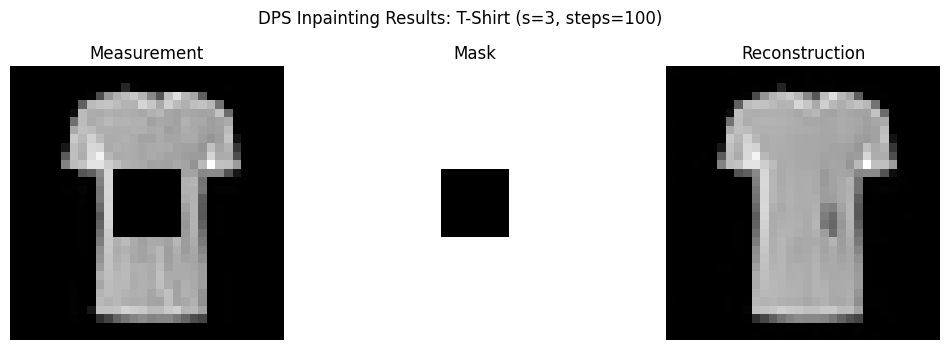

In [37]:
import torch
from torchvision import datasets, transforms

batch_size = 128

# MATCH TRAINING PREPROCESSING: Pad(2) instead of Resize(32)
# The model was trained on 28x28 padded to 32x32 with 0s.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(2), # Valid padding to reach 32x32
])

dataset = datasets.FashionMNIST(
    "../data",
    train=True,
    download=True,
    transform=transform,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

label_to_name_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
}

# Get a batch
x_batch, y_batch = next(iter(loader))

# Select just the first image
x_gt = x_batch[0:1].to(device) # Shape: [1, 1, 32, 32]
gt_class_name = label_to_name_map[y_batch[0].item()]

print(f"Sampled one image from dataset. Ground Truth Class: {gt_class_name}, Shape: {x_gt.shape}")

# 2. Create Measurement (Masked Image)
# Mask: Bottom half missing
mask = torch.ones_like(x_gt).to(device)
mask[:, :, 12:20, 12:20] = 0.0 # Zero out bottom half
measurement = x_gt * mask

# 3. Run DPS
# Using a safer scale and matched transform
print(measurement.shape)
run_inference_dps(unet, emb, gt_class_name, 3, measurement, mask, zeta=0.4, steps=100)
#def run_inference_dps(unet, emb, class_name, s, measurement, mask, zeta=1.0, steps=50):


## 4. Run Comparisons

Running DDIM Sampling (Steps=100)... Fast!


DDIM: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


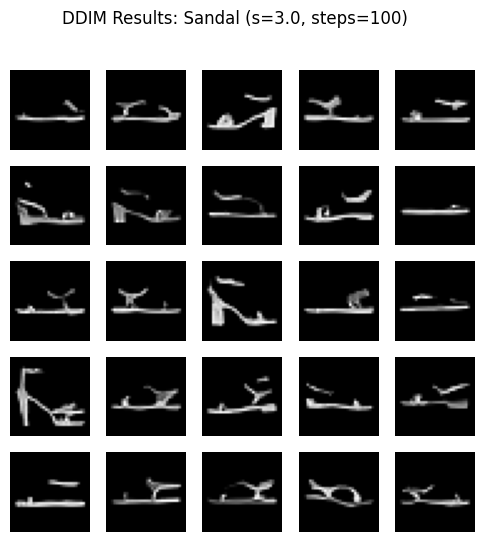

In [38]:
# Run DDIM (Fast)
run_inference_ddim(unet, emb, class_name="Sandal", s=3.0, n_steps=100)

Running DDPM Sampling (T=1000)... this might take a while.


DDPM: 100%|██████████| 1000/1000 [02:46<00:00,  5.99it/s]


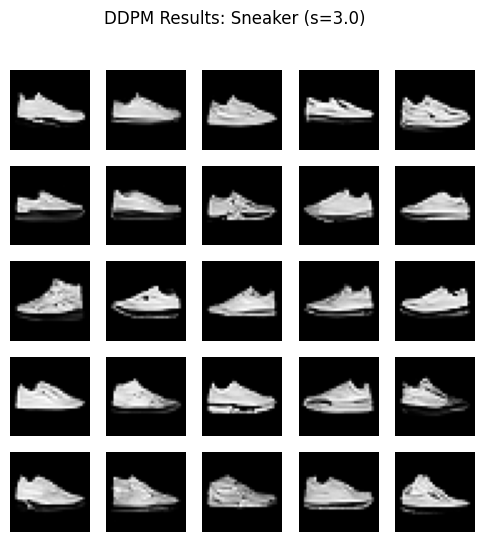

<Figure size 640x480 with 0 Axes>

In [33]:
# Run DDPM (Slow - 1000 steps)
# Uncomment to run
run_inference_ddpm(unet, emb, class_name="Sneaker", s=3.0)